In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import xarray as xr
import xesmf as xe
%matplotlib inline

In [2]:
iclass_dir = '/lustre/or-hydra/cades-arm/proj-shared/iclass/'
dir_input = f'{iclass_dir}cacti/corvisstpx2drectg16v4minnisX1.parallaxcorrected.c1/201901/'
file_in = f'{dir_input}corvisstpx2drectg16v4minnisX1.parallaxcorrected.c1.20190125.173034.cdf'

file_radar = f'{iclass_dir}/cacti/radar_processing/corgridded_terrain.c0/CSAPR2_Taranis_Gridded_500m.Terrain_RangeMask.nc'

weight_file_dir = f'{iclass_dir}/cacti/corvisstpx2drectg16v4minnisX1.regridweights.c1/'
weight_file_binlinear = f'{weight_file_dir}bilinear_728x672_441x441.nc'
weight_file_nearests2d = f'{weight_file_dir}nearest_s2d_728x672_441x441.nc'

dir_output = f'{iclass_dir}cacti/corvisstpx2drectg16v4minnisX1.parallaxcorrected_regrid2csapr2gridded.c1/'
outbasename = 'corvisstpx2drectg16v4minnisX1.regrid2csapr2gridded.c1.'

In [3]:
dir_output

'/lustre/or-hydra/cades-arm/proj-shared/iclass/cacti/corvisstpx2drectg16v4minnisX1.parallaxcorrected_regrid2csapr2gridded.c1/'

In [4]:
# Read destination grid (CSAPR)
ds_dst = xr.open_dataset(file_radar)
ds_dst = ds_dst.drop(labels=('x','y'))
ds_dst = ds_dst.rename({'latitude':'lat', 'longitude':'lon'})
ds_dst = ds_dst.assign_coords({'lon':ds_dst.lon, 'lat':ds_dst.lat})
ds_dst

<xarray.Dataset>
Dimensions:  (x: 441, y: 441)
Coordinates:
    lat      (y, x) float32 ...
    lon      (y, x) float32 ...
Dimensions without coordinates: x, y
Data variables:
    hgt      (y, x) float32 ...
    mask110  (y, x) bool ...
    mask100  (y, x) bool ...
    mask50   (y, x) bool ...
    mask30   (y, x) bool ...
    mask20   (y, x) bool ...
    mask10   (y, x) bool ...
    mask5    (y, x) bool ...
Attributes:
    dx:          0.5
    dy:          0.5
    input_file:  /lustre/or-hydra/cades-arm/proj-shared/iclass/cacti/radar_pr...
    contact:     Zhe Feng, zhe.feng@pnnl.gov
    created_by:  make_cacti_csapr_terrain_range_mask.ipynb

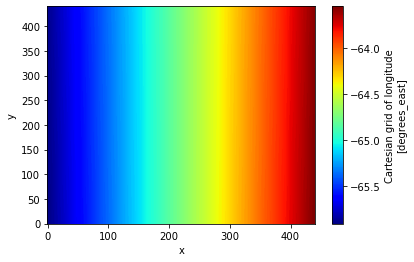

In [5]:
ds_dst.lon.plot(cmap='jet')

In [6]:
# Read data
ds = xr.open_dataset(file_in, drop_variables=('scanline_time','base_time','time_offset'))
ds = ds.rename({'longitude':'lon', 'latitude':'lat'})
ds = ds.rename({'element':'x', 'line':'y'})
ds = ds.assign_coords({'time':ds.time})
# # Change time encoding unit
# time_unit = ds.time.dt.strftime('seconds since %Y-%m-%dT00:00:00.0').values.item()
# # time_unit
# ds.time.encoding['units'] = time_unit
ds

<xarray.Dataset>
Dimensions:                      (x: 672, y: 728)
Coordinates:
    time                         datetime64[ns] ...
    lon                          (y, x) float32 ...
    lat                          (y, x) float32 ...
Dimensions without coordinates: x, y
Data variables:
    reflectance_vis              (y, x) float32 ...
    temperature_sir              (y, x) float32 ...
    temperature_ir               (y, x) float32 ...
    temperature_sw               (y, x) float32 ...
    temperature_wv               (y, x) float32 ...
    cloud_ir_emittance           (y, x) float32 ...
    cloud_phase                  (y, x) float32 ...
    cloud_visible_optical_depth  (y, x) float32 ...
    cloud_particle_size          (y, x) float32 ...
    cloud_lwp_iwp                (y, x) float32 ...
    cloud_effective_temperature  (y, x) float32 ...
    cloud_top_pressure           (y, x) float32 ...
    cloud_effective_pressure     (y, x) float32 ...
    cloud_bottom_pressure        (y, x) float32 ...
    cloud_top_height             (y, x) float32 ...
    cloud_effective_height       (y, x) float32 ...
    cloud_bottom_height          (y, x) float32 ...
    broadband_shortwave_albedo   (y, x) float32 ...
    broadband_longwave_flux      (y, x) float32 ...
    cloud_top_temperature        (y, x) float32 ...
    cloud_bottom_temperature     (y, x) float32 ...
Attributes:
    User_Note:                    All of the datasets provided on this websit...
    NetCDF_Version:               netcdf 4.0.1
    facility_id:                  X1
    site_id:                      cor
    location:                     cor
    zeb_platform:                 corvisstpx2drectg16v4minnisX1.c1
    history:                      2020-02-04T07:12:03UTC Rectilinear files cr...
    input_files:                  GOES-16
    resolution:                   2-km
    reflectance_vis_note1:        effective_wavelength_visst = 0.64 um
    reflectance_vis_note2:        spectral_width_instrument =  0.60 um - 0.68 um
    temperature_sir_note1:        effective_wavelength_visst = 3.9 um
    temperature_sir_note2:        spectral_width_instrument = 3.80 um - 4.0 um
    temperature_ir_note1:         effective_wavelength_visst = 11.2 um
    temperature_ir_note2:         spectral_width_instrument = 10.8 um - 11.6 um
    temperature_sw_note1:         effective_wavelength_visst = 12.4 um
    temperature_sw_note2:         spectral_width_instrument = 11.8 - 12.8 um
    Version:                      V4.2.3
    longwave_NB_BB_correlation:   The LW NB-BB correlation is given by a meth...
    shortwave_NB_BB_correlation:  The SW NB-BB correlation is given by a meth...
    visible_calibration:          The GOES-16 visible calibration equation is...
    IR_calibration:               The GOES-16 IR calibration was based on the...
    VISST:                        NASA-Langley cloud and radiation products a...
    NCO:                          4.3.0
    VERSION:                      This version was processed historically and...

In [7]:
ds.time

<xarray.DataArray 'time' ()>
array('2019-01-25T17:30:34.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2019-01-25T17:30:34
Attributes:
    valid_range:  [    0 86400]
    long_name:    Time offset from base_time
    NOTE:         This is the nominal image time

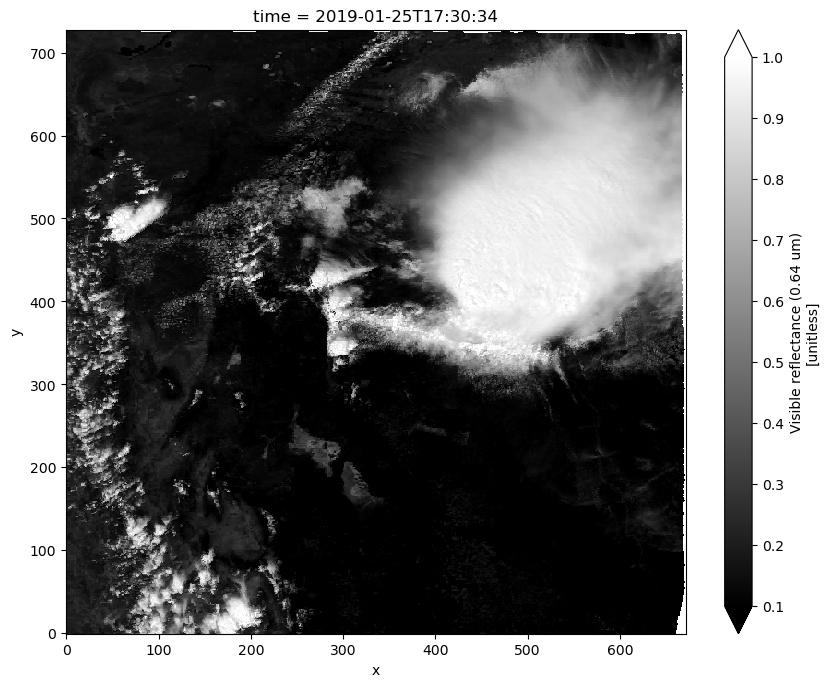

In [8]:
fig = plt.figure(figsize=[10,8], dpi=100)
ds.reflectance_vis.plot(vmin=0.1, vmax=1, cmap='binary_r')
# ds.temperature_ir.plot(vmin=180, vmax=320, cmap='jet')

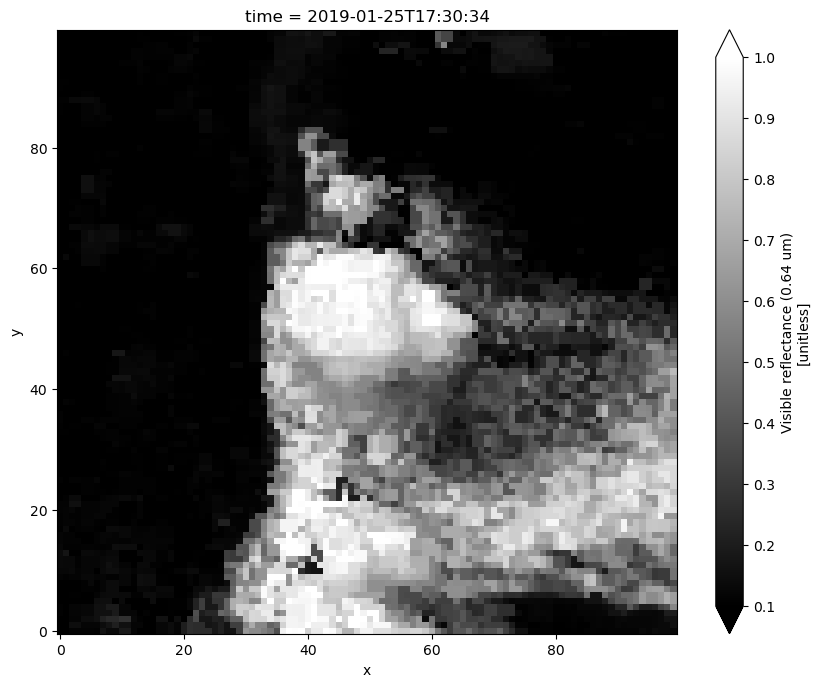

In [9]:
fig = plt.figure(figsize=[10,8], dpi=100)
ds.reflectance_vis.sel(x=slice(250,350), y=slice(300,400)).sel(y=slice(None, None, -1)).plot(vmin=0.1, vmax=1, cmap='binary_r')

In [10]:
# First time running the code, uncomment this line to produce a weight file written to current directory
# regridder = xe.Regridder(ds, ds_dst, 'bilinear')

Reuse existing file: /lustre/or-hydra/cades-arm/proj-shared/iclass//cacti/corvisstpx2drectg16v4minnisX1.regridweights.c1/bilinear_728x672_441x441.nc


In [ ]:
regridder_bl = xe.Regridder(ds, ds_dst, 'bilinear', reuse_weights=True, filename=weight_file_binlinear)

In [11]:
regridder_s2d = xe.Regridder(ds, ds_dst, 'nearest_s2d', reuse_weights=True, filename=weight_file_nearests2d)

Reuse existing file: /lustre/or-hydra/cades-arm/proj-shared/iclass//cacti/corvisstpx2drectg16v4minnisX1.regridweights.c1/nearest_s2d_728x672_441x441.nc


In [12]:
tb_bl = regridder_bl(ds.temperature_ir)
visrefl_bl = regridder_bl(ds.reflectance_vis)
ctt_bl = regridder_bl(ds.cloud_top_temperature)

In [19]:
tb_s2d = regridder_s2d(ds.temperature_ir)
visrefl_s2d = regridder_s2d(ds.reflectance_vis)

In [14]:
# Regrid the entire dataset
ds_out = regridder_s2d(ds)
ds_out = ds_out.expand_dims(dim='time', axis=0)
ds_out

using dimensions ('y', 'x') from data variable reflectance_vis as the horizontal dimensions for this dataset.


<xarray.Dataset>
Dimensions:                      (time: 1, x: 441, y: 441)
Coordinates:
  * time                         (time) datetime64[ns] 2019-01-25T17:30:34
    lon                          (y, x) float32 -65.90939 ... -63.57274
    lat                          (y, x) float32 -33.110184 ... -31.13189
Dimensions without coordinates: x, y
Data variables:
    reflectance_vis              (time, y, x) float64 0.1665 0.1665 ... 0.1283
    temperature_sir              (time, y, x) float64 311.2 311.2 ... 317.6
    temperature_ir               (time, y, x) float64 295.3 295.3 ... 300.7
    temperature_sw               (time, y, x) float64 290.7 290.7 ... 294.6
    temperature_wv               (time, y, x) float64 242.0 242.0 ... 240.5
    cloud_ir_emittance           (time, y, x) float64 0.7277 0.7277 ... nan nan
    cloud_phase                  (time, y, x) float64 1.0 1.0 1.0 ... 4.0 4.0
    cloud_visible_optical_depth  (time, y, x) float64 1.934 1.934 ... nan nan
    cloud_particle_size          (time, y, x) float64 11.35 11.35 ... nan nan
    cloud_lwp_iwp                (time, y, x) float64 12.27 12.27 ... nan nan
    cloud_effective_temperature  (time, y, x) float64 296.6 296.6 ... nan nan
    cloud_top_pressure           (time, y, x) float64 841.2 841.2 ... nan nan
    cloud_effective_pressure     (time, y, x) float64 843.4 843.4 ... nan nan
    cloud_bottom_pressure        (time, y, x) float64 865.1 865.1 ... nan nan
    cloud_top_height             (time, y, x) float64 1.574 1.574 ... 0.0 0.0
    cloud_effective_height       (time, y, x) float64 1.551 1.551 ... nan nan
    cloud_bottom_height          (time, y, x) float64 1.326 1.326 ... nan nan
    broadband_shortwave_albedo   (time, y, x) float64 17.75 17.75 ... 16.13
    broadband_longwave_flux      (time, y, x) float64 289.0 289.0 ... 300.5
    cloud_top_temperature        (time, y, x) float64 296.5 296.5 ... nan nan
    cloud_bottom_temperature     (time, y, x) float64 297.8 297.8 ... nan nan
Attributes:
    regrid_method:  nearest_s2d

In [15]:
outfile_timestr = ds_out.time.dt.strftime('%Y%m%d.%H%M%S').values.item()
outfilename = f'{dir_output}{outbasename}{outfile_timestr}.nc'
print(outfilename)

time_unit = ds_out.time.dt.strftime('seconds since %Y-%m-%dT00:00:00.0').values.item()
print(time_unit)
ds_out.time.encoding['units'] = time_unit

/lustre/or-hydra/cades-arm/proj-shared/iclass/cacti/corvisstpx2drectg16v4minnisX1.parallaxcorrected_regrid2csapr2gridded.c1/corvisstpx2drectg16v4minnisX1.regrid2csapr2gridded.c1.20190125.173034.nc
seconds since 2019-01-25T00:00:00.0


In [16]:
# Set encoding/compression for all variables
comp = dict(zlib=True, dtype='float32')
encoding = {var: comp for var in ds_out.data_vars}
# Update base_time variable dtype as 'double' for better precision
bt_dict = {'time': {'zlib':True, 'dtype':'float64', 'units':time_unit}}
encoding.update(bt_dict)

ds_out.to_netcdf(path=f'{outfilename}', unlimited_dims='time', encoding=encoding)

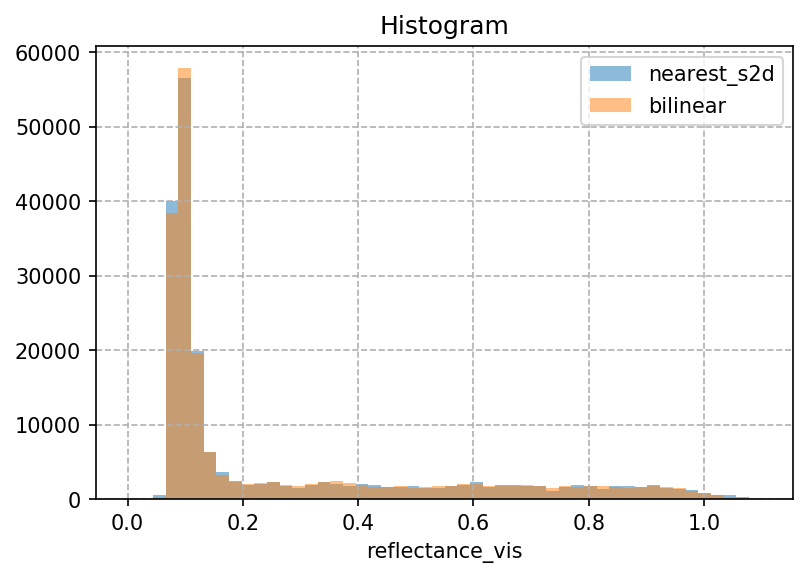

In [17]:
fig = plt.figure(dpi=150)
visrefl_s2d.plot.hist(bins=50, range=(0,1.1), alpha=0.5, label='nearest_s2d')
visrefl_bl.plot.hist(bins=50, range=(0,1.1), alpha=0.5, label='bilinear')
plt.grid(ls='--')
plt.legend()

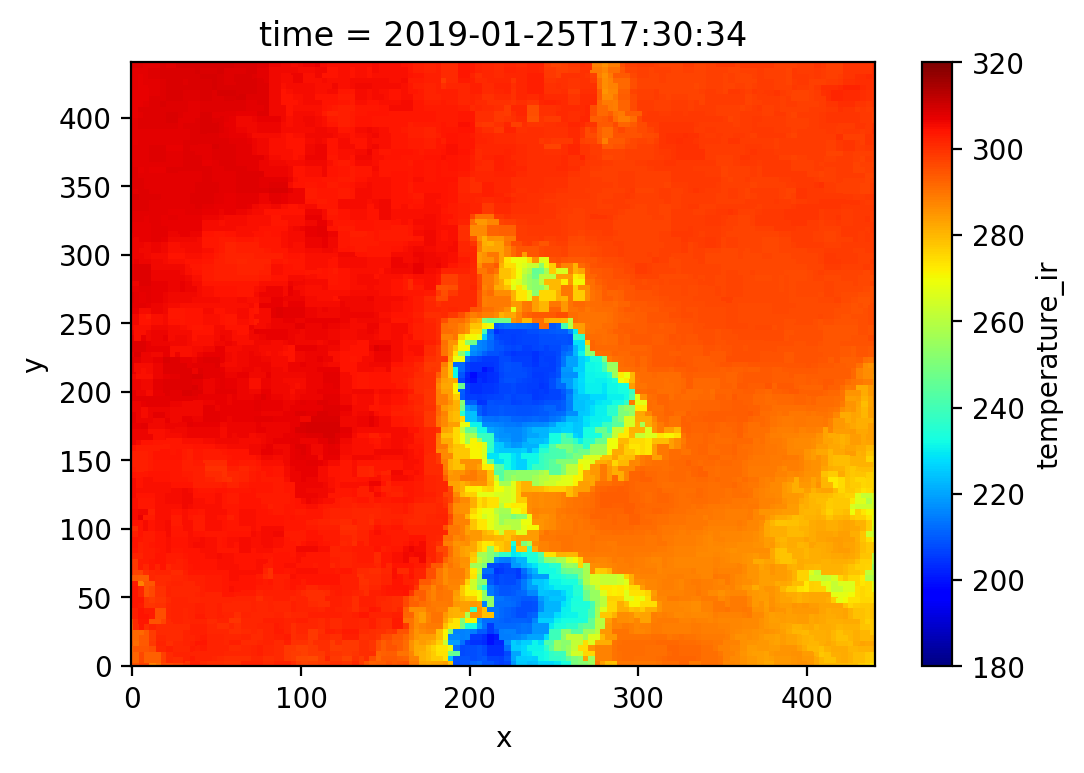

In [20]:
fig = plt.figure(dpi=200)
tb_s2d.plot(vmin=180, vmax=320, cmap='jet')

In [21]:
# fig = plt.figure(dpi=200)
# (ctt_out-273.15).plot(vmin=-80, vmax=20, cmap='gist_rainbow_r')

In [22]:
# fig = plt.figure(dpi=200)
# visrefl_out.plot(vmin=0.1, vmax=1, cmap='binary_r')

In [23]:
# fig = plt.figure(dpi=200)
# visrefl_s2d.plot(vmin=0.1, vmax=1, cmap='binary_r')